In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()


In [3]:
##Style for the graph display 
def sink_final_node(pos,root_node,node, G):
    pos[node] = (pos[node][0], pos[root_node][1] - nx.dag_longest_path_length(G))
def raise_root(pos,root_node,node, G):
    pos[node] = (pos[node][0], pos[root_node][1] + nx.dag_longest_path_length(G))
def adjust_reference(pos,root_node, final_node, Graph):
    pos[root_node] = (pos[root_node][0], pos[root_node][1] - 0.5)
    distances = nx.shortest_path_length(Graph, source=root_node)

    
    # Adjust the y-coordinates of other nodes based on their distances from the root
    for node in sorted(distances, key=distances.get, reverse=True):
        distance = distances[node]
        pos[node] = (pos[node][0], pos[root_node][1] - distance)
    sink_final_node(pos,root_node,final_node,Graph)
    print(root_node)

def get_color_map(graph, interest): 
    color_map = []
    for node in graph:
        if node in interest:
            color_map.append('cyan')
        else: 
            color_map.append('skyblue') 
    return color_map
def d_seperate_with_style(graph, dic1,dic2,conditional):
    color_map = get_color_map(graph,interest)
    nx.draw(g, pos=pos, with_labels=True, node_color = color_map, arrowsize= 20, node_size=700, font_size=10, font_color="black")

    return (nx.d_separated(graph, dic1,dic2,conditional))

In [4]:
##beta observation function (replaced with the door adjustment function)
def observe(observation_node, graph):
    if not any(graph.successors(observation_node)):
        raise Exception("Observation node has no descendants")
    
    # Get incoming edges (edges leading to the observation node)
    edges_to_remove = list(graph.in_edges(observation_node))
    #1231241
    #Remove edges leading to the observation node
    graph.remove_edges_from(edges_to_remove)

    return graph

def observe_and_show(observation_node, grap):
    graph = grap.copy()
    color_map = observe_color_map(observation_node,graph)
    nx.draw(graph, pos=pos, with_labels=True, node_color = color_map, arrowsize= 20, node_size=700, font_size=10, font_color="black")
    display(plt.show())
    return graph

def observe_color_map(observation_node,graph):
    graph = observe(observation_node, graph)
    return get_color_map(graph, [observation_node])


In [5]:
#To string bassically given the grpah, it should return a legible math equation
def as_equation(graph,result, cause_list):
    if not cause_list:
        return "P(" + result + ")"    
    causes = str(cause_list)
    return str("P(" + result + "|" + causes + ")").replace("[", "").replace("]", "")

In [6]:
#front door paths  and backdoor paths helper functions
def front_door_paths(graph, start_node, finish_node):
    all_paths = list(nx.all_simple_paths(graph, source=start_node, target=finish_node))[::-1]

    return all_paths 
def unique(arr):
    return_arr = []
    for a in arr:
        if a not in return_arr:
            return_arr.append(a)
    return return_arr
def back_door_paths(graph, start_node, finish_node):
    # Get all ancestors of the treatment variable
    ancestors_of_treatment = nx.ancestors(graph, start_node)

    # Initialize a set to store backdoor nodes
    backdoor_nodes = []

    # Loop through ancestors
    for ancestor in ancestors_of_treatment:
        # Get descendants of the ancestor
        descendants_of_ancestor = set(nx.descendants(graph, ancestor))
        
        # Check if the outcome variable is in the descendants
        if finish_node in descendants_of_ancestor:
            backdoor_nodes.append(ancestor)
    if backdoor_nodes:
        one_way = ([front_door_paths(graph,back_node,start_node) for back_node in backdoor_nodes])[0]
        one_way = [one[::-1] for one in one_way]
        second_way = ([front_door_paths(graph,back_node,finish_node) for back_node in backdoor_nodes])[0]
        second_way = [arr for arr in second_way if "X" not in arr] if second_way else None
        all_back = [(one + second) for one in one_way for second in second_way]
        all_back = [unique(all) for all in all_back]
        return (all_back)
    else:
        return (None)


In [7]:
#DOOR ADJUSTMENT, works for basic blocking and understnading the output to compensate for the blocked node
def door_adjustment(new_graph,start_node,block_node,out_node):
    given = []
    conditional = [] 
    return_str = ""
    all_fronts = (front_door_paths(new_graph,start_node,out_node))
    all_back = front_door_paths(new_graph,start_node,block_node)
    for front in all_fronts:
        if not block_node in (new_graph.successors(start_node)):
            front.insert(0,block_node)
        given.append(front)
    for back in all_back:
        conditional.append(back)

    for giv in given:
        if giv:
            return_str += (as_equation(new_graph,giv[-1],giv[:-1:]))
            
    if conditional:
        for cond in conditional:
    
            if cond:
                return_str += (as_equation(new_graph,cond[-1],cond[:-1:]))
            else:
                return_str += (as_equation(new_graph,cond,cond))
    else:
        return_str += (as_equation(new_graph,block_node,conditional))
    print ("P(" + out_node+"|"+start_node+")= " +"Sigma("+block_node+")"+ return_str)
    return observe_and_show(block_node,G)
    
                
        

In [37]:
#P(y|do(x), z, w) = P(y|do(x), w)
#if (Y ⊥⊥ Z|X, W)GX
#conditioning on x, if z is irrelevent (d seperated) when blocking the inputs to X, the probability is equal to it without
#x is the do variable
#y is the effect 
# z is the irrelevent_set
#w is the relevent set
def rule_one(graph, effect_set, do_variable_set, irrelevent_set):
    g_copy = graph.copy()

    edges_to_remove = list(graph.in_edges(do_variable_set))
    g_copy.remove_edges_from(edges_to_remove)

    # g_copy is the modified graph where do_variable_set has no input edges
    # nx.d_separated conditions on something, so if we're testing for pure d-separation,
    # conditioning on the effect_set has the same result
    # and returns True if it is in fact D separated
    print({do_variable_set}.union({irrelevent_set}))
    condition = nx.d_separated(g_copy, {effect_set}, {do_variable_set}.union({irrelevent_set}), {do_variable_set})
    if condition:
        print("rule 1 passed")
    return condition
    


In [9]:
##mmost functions below are toDO, turned out to be trickier than expected notebly the unblockable doors
def rule_three(graph, obseration, outcome, irrelevent_set):
    print("yet to be implimented")
    return None


In [10]:
def rule_two(graph,observation,outcome,irrelevent_set):
    print("yet to be implimented")
    return None

In [11]:
def unblockable_front_doors(graph, observation, outcome):
    print("yet to be implimented")
    return None 

In [12]:
def unblockable_back_doors(graph, observation, outcome):
    print("yet to be implimented")
    return None 

In [13]:
def find_front_condition_on_fork_or_chain(graph,observe_node,outcome):
    print('needs to be implimented')
    return None 

In [14]:
def find_back_condition_on_fork_or_chain(graph,observe_node,outcome):
    print('needs to be implimented')
    return None 

In [15]:
##Adapted from the recursive Psuedo Code in the beginning of the packet for single outcomes
#needs alot of helper functions still working on it, lowkey underestimeated it lmao 
def main(graph,observation,outcome, equation_so_far = ""):
    if equation_so_far != "":
        ## for each equation so far, run it through the main as observations and outcomes and return it recurssibley
        print("needs to be implimented")
    back_paths = back_door_paths(graph,observation,outcome)
    front_paths = front_door_paths(graph,observation,outcome)
    if back_paths is None and front_paths is None:
        equation_so_far += rule_three(graph,observation,outcome)
    elif back_paths is None and not (front_paths is None):
        equation_so_far += rule_two(graph,observation,outcome)
    elif not (back_paths is None )and (front_paths is None):
        equation_so_far += rule_three(graph,observation,outcome)
    else:
        print("conditioning required")
        unblockable_front = unblockable_front_doors(graph, observation, outcome)
        unblockable_back = unblockable_back_doors(graph, observation, outcome)
        observe_node = "";
        if unblockable_back is None and (not unblockable_front is None):
            observe_node = find_front_condition_on_fork_or_chain(graph,observe_node,outcome)
            graph = door_adjustment(graph,observation,observe_node,outcome)
            equation_so_far = rule_two(graph,observation,outcome)
            return main(graph,observation,outcome, equation_so_far)
        elif (not unblockable_back) is None and  unblockable_front is None:
            observe_node = find_back_condition_on_fork_or_chain(graph,observe_node,outcome)
            graph = door_adjustment(graph,observation,observe_node,outcome)
            equation_so_far = rule_three(graph,observation,outcome)
            return main(graph,observation,outcome, equation_so_far)
        else:
            return equation_so_far
    
    main(graph, observation, outcome, equation_so_far)


            
        


U


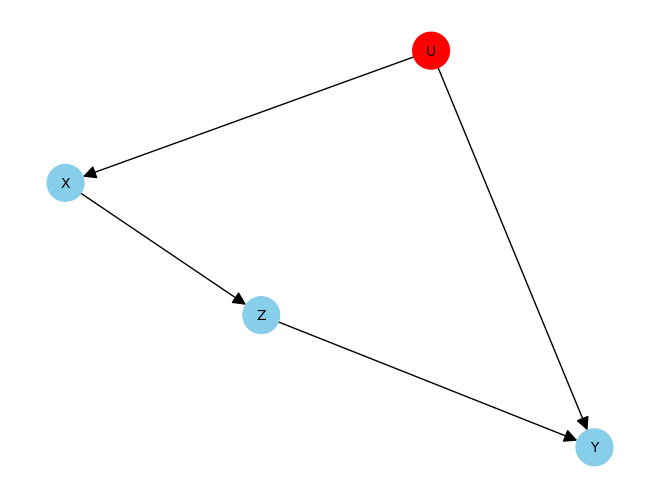

In [49]:
G = nx.DiGraph()
G.add_edges_from([("U","X"),("U","Y"),("X","Z"),("Z","Y")])
pos = nx.spring_layout(G, seed = 15)

# Find the root node (assumed to have in-degree zero)
root_node = [node for node, in_degree in G.in_degree() if in_degree == 0][0]

# Calculate the shortest path lengths from the root node to all other nodes

# Adjust the y-coordinate of the root node to place it in the lower half

adjust_reference(pos,root_node,"Y", G)
nx.draw(G, pos=pos, with_labels=True, arrowsize= 20, node_size=700, node_color=["red","skyblue","skyblue","skyblue"], font_size=10, font_color="black")


In [50]:
front = front_door_paths(G, "X", "Y")
front

[['X', 'Z', 'Y']]

In [51]:
back = back_door_paths(G, "X", "Y")
back

[['X', 'U', 'Y']]

P(Y|X)= Sigma(Z)P(Y|'X', 'Z')P(Z|'X')


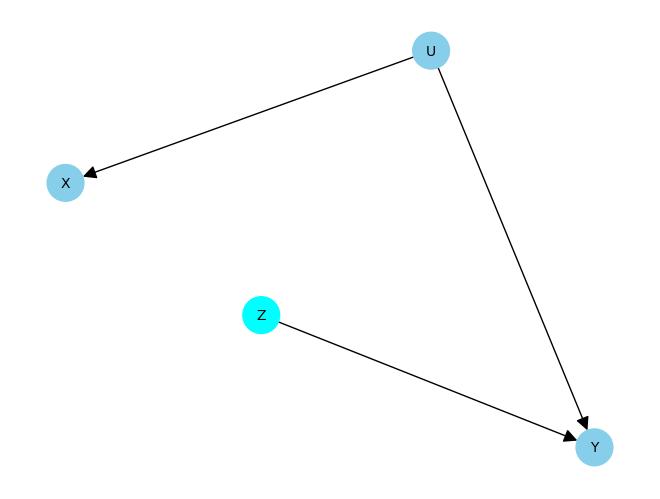

None

In [52]:

display(door_adjustment(G, start_node="X", block_node="Z", out_node="Y"))
#displays the door adjustment and prints the starting equation, doesnt change the graph G but returns the edited graph



P(Y|Z)= Sigma(X)P(Y|'X', 'Z')P(X)


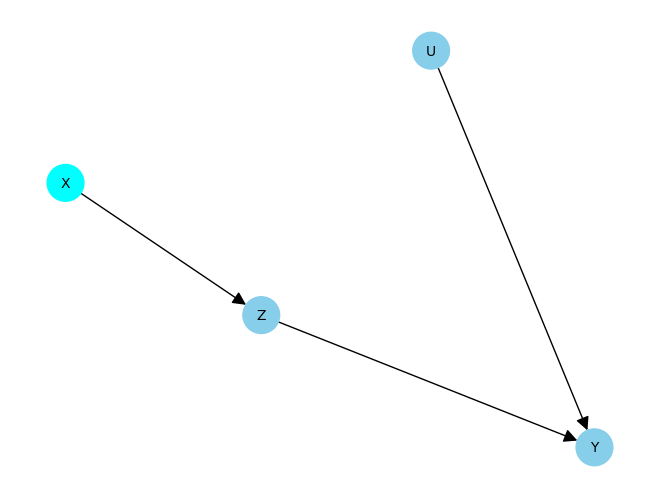

None

In [53]:
display(door_adjustment(G,start_node= "Z",block_node="X", out_node="Y"))
#G is not changed but this functino shows and returns a modified graph showing kinda how the door adjustment "blocked a path"


In [21]:
#format(G, "X", "Y",front)

In [22]:
#(format(G, "X", "Y",back))

In [23]:
#observe_and_show("Z",G)

W


None

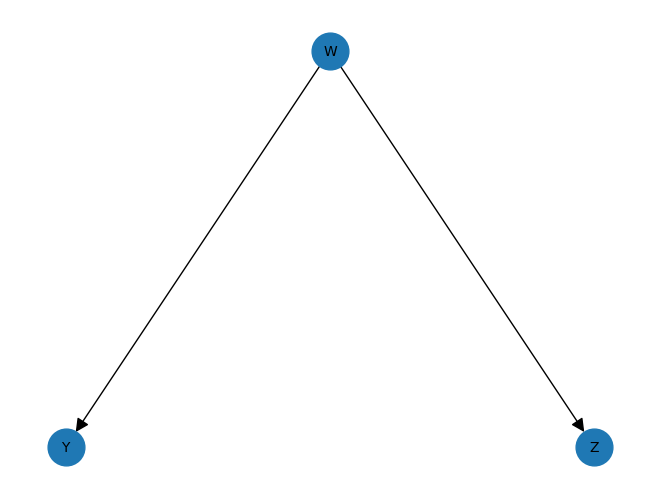

In [39]:
g = nx.DiGraph()
g.add_edges_from(
    [
        ("W", "Z"),
        #("X", "Z"),
        #("X", "Y"),
        ("W", "Y"),
        #("W", "X"),


    ]
)
pos = nx.spring_layout(g, seed = 12)

# Find the root node (assumed to have in-degree zero)
root_node = [node for node, in_degree in g.in_degree() if in_degree == 0][0]

# Calculate the shortest path lengths from the root node to all other nodes

# Adjust the y-coordinate of the root node to place it in the lower half

adjust_reference(pos,root_node,"Z",g)
plt.show()
# states/obs before 'S3' are d-separated from states/obs after 'S3'
display(nx.draw(g, pos=pos, with_labels=True, arrowsize= 20, node_size=700, font_size=10, font_color="black"))

In [40]:
temp = rule_one(g,"Z","W","Y")

{'W', 'Y'}
rule 1 passed


S1


None

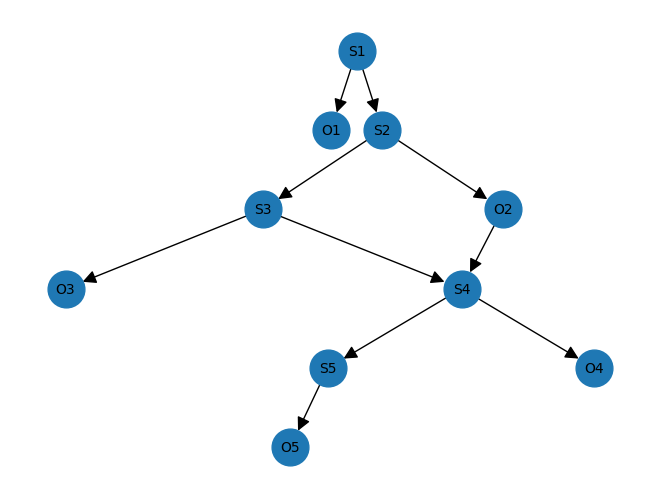

None

['S1', 'S2', 'S3', 'S4', 'S5', 'O1', 'O2', 'O3', 'O4', 'O5']
False


In [41]:
g = nx.DiGraph()
g.add_edges_from(
    [
        ("S1", "S2"),
        ("S2", "S3"),
        ("S3", "S4"),
        ("S4", "S5"),
        ("S1", "O1"),
        ("S2", "O2"),
        ("S3", "O3"),
        ("S4", "O4"),
        ("O2","S4"),
        ("S5", "O5"),
    ]
)
pos = nx.spring_layout(g, seed = 12)

# Find the root node (assumed to have in-degree zero)
root_node = [node for node, in_degree in g.in_degree() if in_degree == 0][0]

# Calculate the shortest path lengths from the root node to all other nodes

# Adjust the y-coordinate of the root node to place it in the lower half

adjust_reference(pos,root_node,"O5",g)

# Show the plot
plt.show()
# states/obs before 'S3' are d-separated from states/obs after 'S3'
display(nx.draw(g, pos=pos, with_labels=True, arrowsize= 20, node_size=700, font_size=10, font_color="black"))
display(plt.show())



print(g.nodes)

print(nx.d_separated(g, { "S2","S3","O3","S4","O4","S5","O5"}, { "O2"}, {"S2"}))


In [42]:
back_door_paths(g, "O5", "O4")

[['O5', 'S5', 'S4', 'S3', 'O4']]

Z0


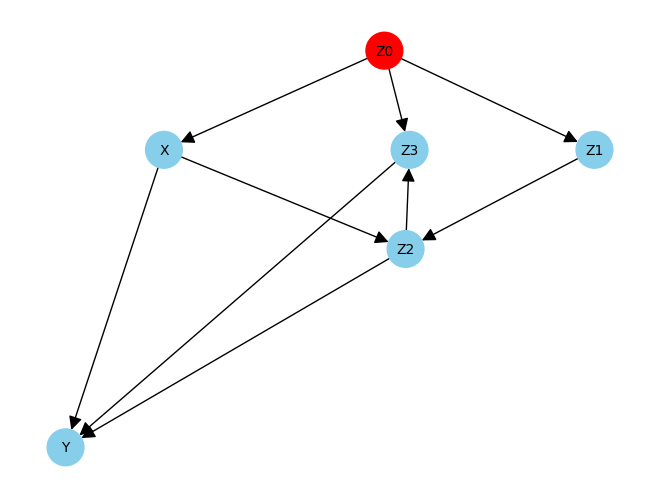

In [43]:
# Add edges and nodes to the graph (replace this with your own graph structure)
G = nx.DiGraph()

G.add_edges_from([("Z0", "Z1"), ("Z1", "Z2"), ("Z2", "Y"), ("X", "Y"), ("Z0", "X"), ("Z0", "Z3"),("Z3", "Y"),("X", "Z2"),("Z2", "Z3")])

# Specify the spring layout
pos = nx.spring_layout(G, seed = 15)

# Find the root node (assumed to have in-degree zero)
root_node = [node for node, in_degree in G.in_degree() if in_degree == 0][0]

# Calculate the shortest path lengths from the root node to all other nodes

# Adjust the y-coordinate of the root node to place it in the lower half

adjust_reference(pos,root_node,"Y", G)
nx.draw(G, pos=pos, with_labels=True, arrowsize= 20, node_size=700, node_color=["red","skyblue","skyblue","skyblue","skyblue","skyblue"], font_size=10, font_color="black")

# Show the plot
plt.show()

In [46]:


rule_one(G,"Y","X","Z0")



{'X', 'Z0'}


False